In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from utils import *
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter


%matplotlib inline

#increase plot size
plt.rcParams['figure.figsize'] = [20, 10]

import numpy as np
# maximum print option
np.set_printoptions(linewidth=400)

from model import Schelling

In [2]:
model = Schelling(width = 50, height = 50, density = 0.75, minority_pc = 0.3, homophily = 3,  policy = 'similar_history_neighborhood', follow_policy=1.0)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/Users/richard/University/css/css/model.py:115: UserWarning: Agent 0 is being placed with
place_agent() despite already having the position (0, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/Users/richard/University/css/css/model.py:115: UserWarning: Agent 1 is being placed with
place_agent() despite already having the position (0, 1). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(agent, (x, y))
/Users/richard/University/css/css/model.py:115: UserWarning: Agent 2 is being placed with
place_agent() despite already having 

In [3]:
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps)  # Show how many steps have actually run

10


In [4]:
model_out = model.datacollector.get_model_vars_dataframe()

In [5]:
model_out

,perc_happy,segregation
0,0.727606,0.590100
1,0.922996,0.643269
2,0.972761,0.656365
3,0.986380,0.663567
4,0.994762,0.665663
5,0.997381,0.667103
6,0.998428,0.667365
7,0.999476,0.667496
8,0.999476,0.667758
9,1.000000,0.667758


(0.7276060764798323, 1.0)

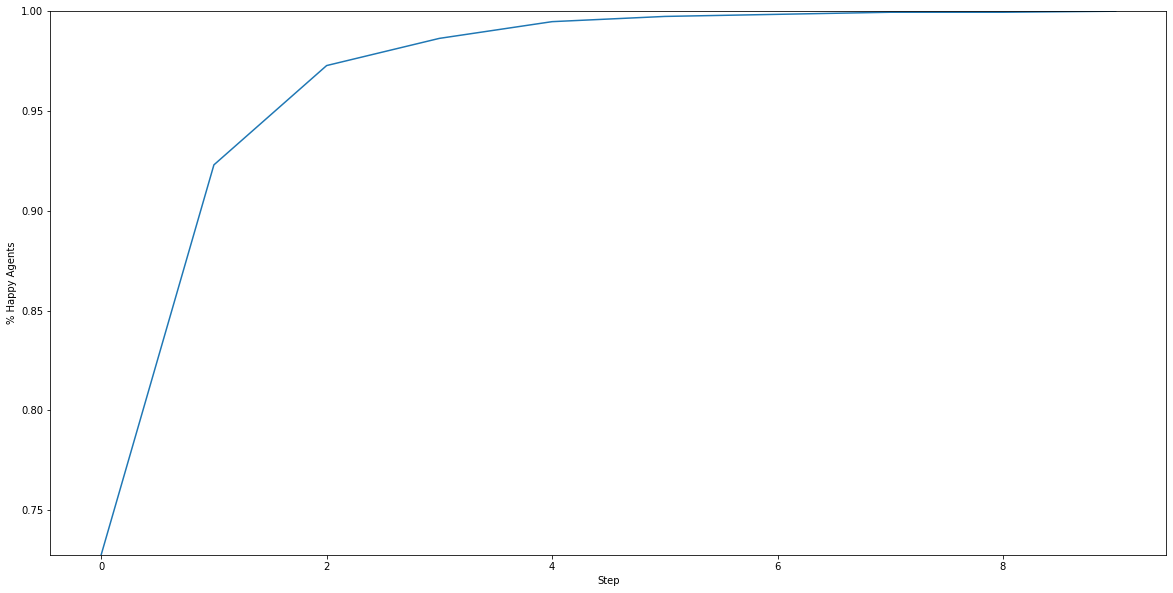

In [6]:
model_out.perc_happy.plot()
plt.xlabel("Step")
plt.ylabel("% Happy Agents")
plt.ylim(min(model_out.perc_happy),1)


Text(0, 0.5, '<S>')

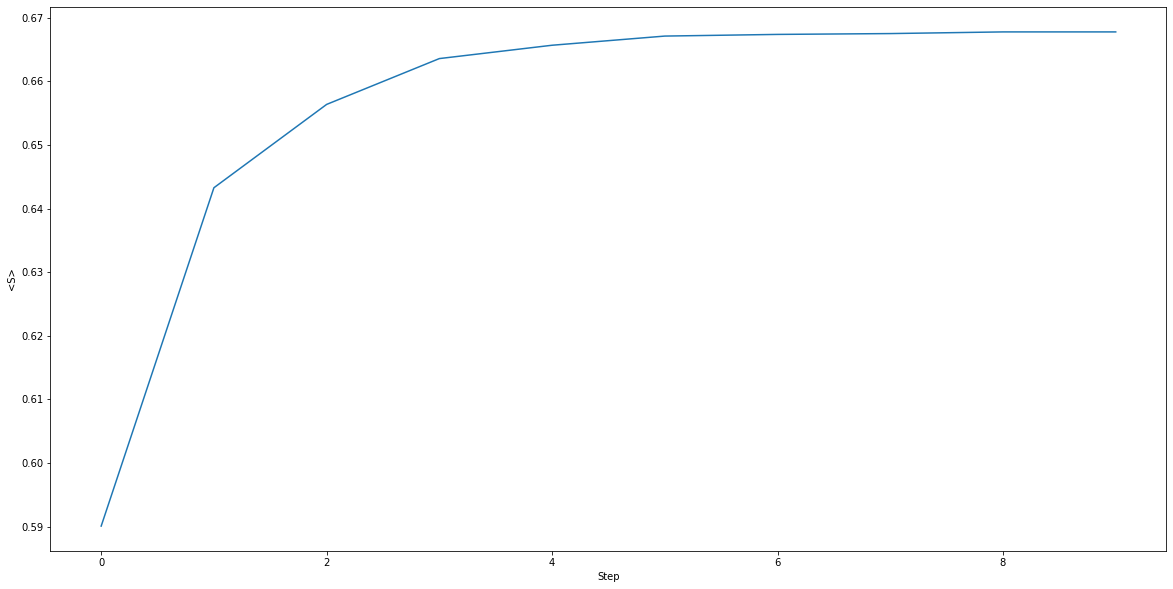

In [7]:
model_out.segregation.plot()
plt.xlabel("Step")
plt.ylabel("<S>")

# Effect of Homophily on segregation

Now, we can do a parameter sweep to see how segregation changes with homophily.

First, we create a function which takes a model instance and returns what fraction of agents are segregated -- that is, have no neighbors of the opposite type.

In [ ]:
from mesa import batch_run

Now, we set up the batch run, with a dictionary of fixed and changing parameters. Let's hold everything fixed except for Homophily.

In [ ]:
fixed_params = {
    'width': 50,
    'height': 50,
    'density': 0.75,
    'minority_pc': 0.4,
    'homophily': 3,
}

#policies = ["random", "distance", "relevance", "distance_relevance", "rich_neighborhood", "poor_neighborhood", "minimum_improvement", "maximum_improvement", "recently_emptied", "historically_emptied" ]

policies = ["random", "distance_relevance", "rich_neighborhood", 
            "minimum_improvement", "maximum_improvement", "recently_emptied", 
            "similar_neighborhood", "different_neighborhood" ]

percentages = [i / 10 for i in range(0,11)]

variable_parms = {"policy": policies, "follow_policy": percentages}

merged_params = {**fixed_params, **variable_parms}
merged_params 

In [ ]:
pd.options.mode.chained_assignment = None

results = batch_run(
    Schelling,
    parameters = merged_params,
    iterations=50,
    max_steps=100,
    number_processes = None
);

results_df = pd.DataFrame(results)


In [ ]:
#results_df.to_csv("results.csv", index=False)
#results_df = pd.read_csv("results.csv")

In [ ]:
results_df = results_df[["RunId", "iteration", "Step", "follow_policy", "policy",  "segregation"]]
#calculate the average Step and the average segregation, across different iteration and policy
results_df_g = results_df.groupby(['policy', 'follow_policy']).mean().reset_index()
results_df_g.head(20)

In [ ]:
#per each policy, extract the timeseries of Step and segregation
results_df_g_step = results_df_g.pivot(index='follow_policy', columns='policy', values='Step')
results_df_g_segregation = results_df_g.pivot(index='follow_policy', columns='policy', values='segregation')



In [ ]:
#plot the timeseries of Step
results_df_g_step.plot()
plt.xlabel("Follow Policy (%)")
plt.ylabel("nr. steps")

In [ ]:
#plot the timeseries of S
results_df_g_segregation.plot()
plt.xlabel("Follow Policy (%)")
plt.ylabel("<S>")

In [ ]:
results_df

In [ ]:
#in results_df_g_std, calculate both the standard deviation and the mean of Step and segregation, across different iteration and policy

results_df_g_std = results_df.groupby(['policy', 'follow_policy']).agg({'Step': ['std', 'mean'], 'segregation': ['std', 'mean']}).reset_index()
results_df_g_std.columns = results_df_g_std.columns.droplevel(0)
results_df_g_std.columns = ['policy', 'follow_policy', 'Step_std', 'Step_mean', 'segregation_std', 'segregation_mean']
results_df_g_std.head(20)

In [ ]:
results_df_g_mean_step = results_df_g_std.pivot(index='follow_policy', columns='policy', values='Step_mean')
results_df_g_std_step = results_df_g_std.pivot(index='follow_policy', columns='policy', values='Step_std')

results_df_g_std_segregation = results_df_g_std.pivot(index='follow_policy', columns='policy', values='segregation_std')
results_df_g_mean_segregation = results_df_g_std.pivot(index='follow_policy', columns='policy', values='segregation_mean')



In [ ]:
#join all the columns of the dataframe, so that we have the standard deviation and the mean of Step and segregation, per each policy, with different colors
for column in results_df_g_std_step.columns:
    if column == "random": #the baseline must be thicker and a normal line without error bars
        #plt.plot(results_df_g_mean_step.index, results_df_g_mean_step[column], label=column, linewidth=5, color = "black")
        plt.errorbar(results_df_g_mean_step.index, results_df_g_mean_step[column], yerr=results_df_g_std_step[column], label=column, linewidth=5, color = "black")
    else:
        plt.errorbar(results_df_g_mean_step.index, results_df_g_mean_step[column], yerr=results_df_g_std_step[column], label=column)

plt.xlabel("Follow Policy (%)", fontsize=18)
plt.ylabel("nr. steps", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left')
plt.show()
    

In [ ]:
for column in results_df_g_std_segregation.columns:
    if column == "random": #the baseline must be thicker and a normal line without error bars
        plt.errorbar(results_df_g_mean_segregation.index, results_df_g_mean_segregation[column], yerr=results_df_g_std_segregation[column], label=column, linewidth=5, color = "black")
    else:
        plt.errorbar(results_df_g_mean_segregation.index, results_df_g_mean_segregation[column], yerr=results_df_g_std_segregation[column], label=column)

plt.xlabel("Follow Policy (%)", fontsize=18)
plt.ylabel("segregation", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left')
plt.show()
